### In this notebook the LODES survey was filtered to contain only NYC data

In [2]:
import zipfile 
import pysal as ps
%matplotlib inline
import numpy as np
import ast
import json
import urllib
import urllib2
from cStringIO import StringIO
import pandas as pd
import requests
import os
import geopandas as gpd
import matplotlib.pylab as pl
from fiona.crs import from_epsg
import matplotlib.pylab as pl
from matplotlib import colors
import shapely
import seaborn as sns
import gzip
import mapreduce as mr
import csv

Columns from LODES 
1 w_geocode Char15 Workplace Census Block Code
2 h_geocode Char15 Residence Census Block Code
3 S000 Num Total number of jobs
4 SA01 Num Number of jobs of workers age 29 or younger12
5 SA02 Num Number of jobs for workers age 30 to 5412
6 SA03 Num Number of jobs for workers age 55 or older12
7 SE01 Num Number of jobs with earnings $1250/month or less
8 SE02 Num Number of jobs with earnings $1251/month to $3333/month
9 SE03 Num Number of jobs with earnings greater than $3333/month
10 SI01 Num Number of jobs in Goods Producing industry sectors
11 SI02 Num Number of jobs in Trade, Transportation, and Utilities industry sectors
12 SI03 Num Number of jobs in All Other Services industry sectors
13 createdate Char Date on which data was created, formatted as YYYYMMDD 

#### Get target Census Blocks from previously created file

In [3]:
CensusBlocks = gpd.GeoDataFrame.from_file('Data/NewCensusBlocks.geojson')

In [7]:
valCBlist = set(CensusBlocks[CensusBlocks["Within30min"] == True]['bctcb_2010'])
len(valCBlist)

4874

C:\Users\ferna\Anaconda2\lib\site-packages\geopandas\plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


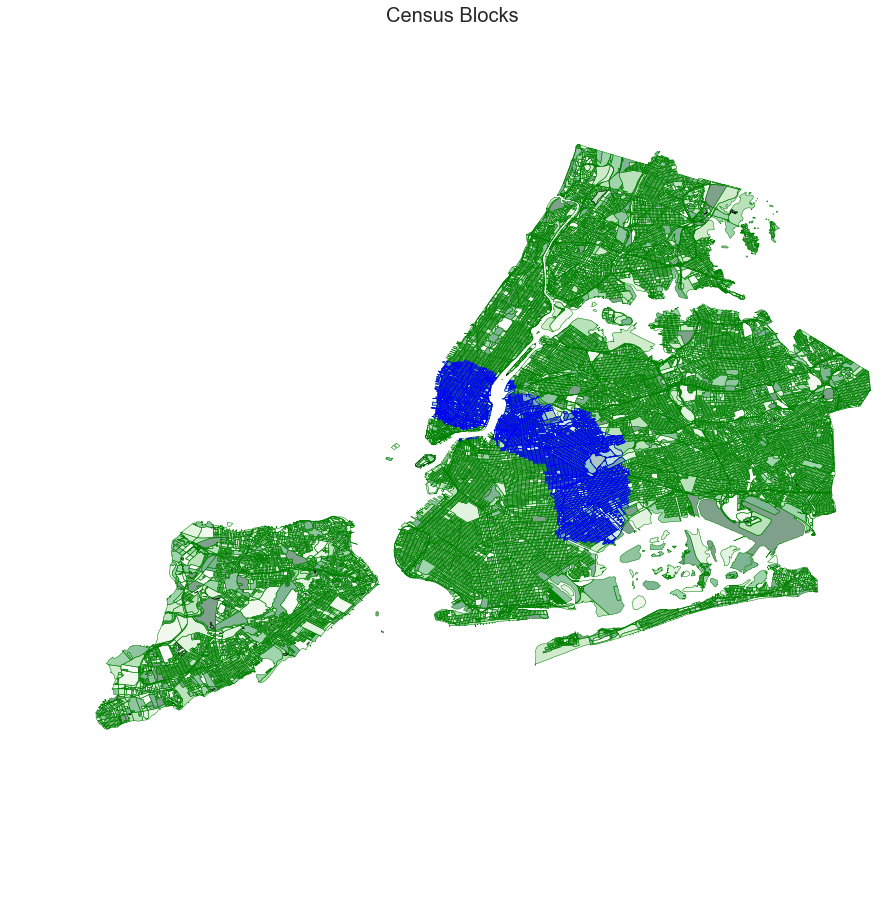

In [5]:
f, ax = pl.subplots(figsize=(15,15))
CensusBlocks.plot(c = 'green', linewidth = .5, ax = ax,  cmap = 'Greens', label = 'parks')
CensusBlocks[CensusBlocks["Within30min"] == True].plot(c = 'blue', linewidth = .5, ax = ax,  cmap = 'Blues', label = 'parks')
pl.axis('off')
ticks = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
pl.title("Census Blocks", size = 20)

#### Get Origin-Destination data filtered 

These are the census reference numbers for each county/borough, we are going to filter all the counties out of NYC.
36005	Bronx, NY	C	bronx code 2
36081	Queens, NY	C	queens code 4
36047	Kings, NY	C	brooklyn code 3
36061	New York, NY	C	manhattan code 1
36085	Richmond, NY	C	staten i code 5

### Mapping the and reducing the 2014 NYC LODES helps to group them by census block and track

In [10]:
## start by filtering by work place, we are not interest in residences or jobs outside of NYC
def mapper1(row):
    if row['w_geocode'][:5] == '36005':
        yield ('2'+row['w_geocode'][5:], row['h_geocode'], int(row['S000']),'2'+ row['w_geocode'][5:-4], row['h_geocode'])
    if row['w_geocode'][:5] =='36081':
        yield ('4'+row['w_geocode'][5:], row['h_geocode'], int(row['S000']),'4'+ row['w_geocode'][5:-4], row['h_geocode'])
    if row['w_geocode'][:5] =='36047':
        yield ('3'+row['w_geocode'][5:], row['h_geocode'], int(row['S000']),'3'+ row['w_geocode'][5:-4], row['h_geocode'])
    if row['w_geocode'][:5] =='36061':
        yield ('1'+row['w_geocode'][5:], row['h_geocode'], int(row['S000']),'1'+ row['w_geocode'][5:-4], row['h_geocode'])   
    if row['w_geocode'][:5] =='36085':
        yield ('5'+row['w_geocode'][5:], row['h_geocode'], int(row['S000']),'5'+ row['w_geocode'][5:-4], row['h_geocode'])

fileUrl = 'https://lehd.ces.census.gov/data/lodes/LODES7/ny/od/ny_od_main_JT00_2014.csv.gz' ###LODES 2014 NY State
filebuffer = urllib.urlretrieve(fileUrl, filename='ny_od_main_JT00_2014.csv.gz')
with gzip.open('ny_od_main_JT00_2014.csv.gz', 'rb') as f:
    reader = csv.DictReader(f)
    output1 = list(mr.run(reader, mapper1))
print len(output1)
with open('Data/True_nyod_JT00thegood_2014.csv', 'w') as f:
    wr = csv.writer(f, quoting = csv.QUOTE_ALL)
    wr.writerow(["w_geocode", "h_geocode", "S000", "w_track", "h_track",])
    map(wr.writerow,output1)
    
output1[:10]

2859989


[('20002001002', '360050002003011', 1, '2000200', '360050002003011'),
 ('20002001002', '360050090003000', 1, '2000200', '360050090003000'),
 ('20002001002', '360050090004000', 1, '2000200', '360050090004000'),
 ('20002001002', '360050090004003', 1, '2000200', '360050090004003'),
 ('20002001004', '360050090003000', 1, '2000200', '360050090003000'),
 ('20002001004', '360050125002004', 1, '2000200', '360050125002004'),
 ('20002001004', '360050166001007', 1, '2000200', '360050166001007'),
 ('20002001004', '360050358004000', 1, '2000200', '360050358004000'),
 ('20002001004', '360610174021001', 1, '2000200', '360610174021001'),
 ('20002001004', '361190036001002', 1, '2000200', '361190036001002')]

In [11]:
## filtering by residence place, we are not interest in residences or jobs outside of NYC
def mapper2(row):
    if row['h_geocode'][:5]=='36005':
        yield (row['w_geocode'], '2'+row['h_geocode'][5:], int(row['S000']), row['w_track'], '2'+row['h_geocode'][5:-4])
    if row['h_geocode'][:5]=='36081':
        yield (row['w_geocode'], '4'+row['h_geocode'][5:], int(row['S000']), row['w_track'], '4'+row['h_geocode'][5:-4])
    if row['h_geocode'][:5]=='36047':
        yield (row['w_geocode'], '3'+row['h_geocode'][5:], int(row['S000']), row['w_track'], '3'+row['h_geocode'][5:-4])
    if row['h_geocode'][:5]=='36061':
        yield (row['w_geocode'], '1'+row['h_geocode'][5:], int(row['S000']), row['w_track'], '1'+row['h_geocode'][5:-4])   
    if row['h_geocode'][:5]=='36085':
        yield (row['w_geocode'], '5'+row['h_geocode'][5:], int(row['S000']), row['w_track'], '5'+row['h_geocode'][5:-4])
        
with open('Data/True_nyod_JT00thegood_2014.csv', 'r') as fi:
    reader1 = csv.DictReader(fi)
    output2 = list(mr.run(reader1,mapper2))
print len(output2)

with open('Data/True_nyod_JT00thegood_2014.csv', 'w') as f:
    wr = csv.writer(f, quoting=csv.QUOTE_ALL)
    wr.writerow(["w_geocode", "h_geocode", "S000","w_track", "h_track",])
    map(wr.writerow,output2)
output2[:10]

2307952


[('20002001002', '20002003011', 1, '2000200', '2000200'),
 ('20002001002', '20090003000', 1, '2000200', '2009000'),
 ('20002001002', '20090004000', 1, '2000200', '2009000'),
 ('20002001002', '20090004003', 1, '2000200', '2009000'),
 ('20002001004', '20090003000', 1, '2000200', '2009000'),
 ('20002001004', '20125002004', 1, '2000200', '2012500'),
 ('20002001004', '20166001007', 1, '2000200', '2016600'),
 ('20002001004', '20358004000', 1, '2000200', '2035800'),
 ('20002001004', '10174021001', 1, '2000200', '1017402'),
 ('20002002002', '20002001003', 1, '2000200', '2000200')]

#### The file ''True_nyod_JT00thegood_2014.csv'' containS the borough code, census track, block and quantity information for every residence and job in NYC